# Data Science Jungle: Large firm or Small Firm; AWS or GCP; Countires with best salaries
We are set to explore the kaggle 2020 survey for insights on what is the difference between working for large company vs small company, what is the next tech to learn and how can datascientists better their salary.<br>
**List of questions to be answered**<br>
1) What is the difference in working for small and large firm?<br>
2) What is the cloud technology kagglers looking to learn in next 2 years?<br>
3) How does experience,country living and language known influence data science salary?<br>

In [88]:
#All imports 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
from plotly import subplots
import plotly.figure_factory as ff
import plotly as py
import plotly.graph_objects as go
init_notebook_mode(connected=True)
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import plotly.io as pio
#pio.renderers.default="svg"

**Gathering data**

In [89]:
#reading csv and see 20k respondents
df=pd.read_csv("data/kaggle_survey_2020_responses.csv")
#Let us investigate the list of columns and let us drop second row with questions text
df=df.iloc[1:]

**Investigating the data**

print("Survey (No of respondents,No of questions answered):",df.shape)


In [90]:
print("Survey (No of respondents,No of questions answered):",df.shape)

Survey (No of respondents,No of questions answered): (20036, 355)


In [91]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20036 entries, 1 to 20036
Columns: 355 entries, Time from Start to Finish (seconds) to Q35_B_OTHER
dtypes: object(355)
memory usage: 54.3+ MB
None


Check missing values

In [92]:
df.isnull().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q3                                         0
Q4                                       467
                                       ...  
Q35_B_Part_7                           19556
Q35_B_Part_8                           19190
Q35_B_Part_9                           19517
Q35_B_Part_10                          16954
Q35_B_OTHER                            19785
Length: 355, dtype: int64

# **First Question we are tackling is what are the differences encountered in a large firm vs small firm in datascience?**

Analysing the data

In [93]:
#check distribution of employess based on the company size
df['Q20'].value_counts(dropna=False)

NaN                         8633
0-49 employees              4208
10,000 or more employees    2238
1000-9,999 employees        1934
50-249 employees            1671
250-999 employees           1352
Name: Q20, dtype: int64

**Cleaning the date**<br>
Dropping all NaN in column Size as they are not useful to determine the company size<br>
Bucketing all <1000 employees firms as small and >=1000 firms as big


In [94]:
#Dropping all NaN in column Size as they are not useful to determine the company size
df = df[df['Q20'].notna()]
print("Number of respondents with valid company size:",df.shape[0])
df_size=df['Q20'].value_counts(dropna=False)

Number of respondents with valid company size: 11403


In [95]:
#Let us tag each of the company into a bucket based on size
#writing a function to categorise <1000 employees as small and >=1000 as big
def get_corp_type(row):
    '''
    Classifies each surveyor into company type based on <1000 employees as small and >=1000 as big
    Parameters: 
        dataframe row(obj):the row to be classified
    Returns:
        corp_type(str):The string based on classification
    '''
    
    if row['Q20']=='0-49 employees':
        return 'small'
    if row['Q20']=='50-249 employees':
        return 'small'
    if row['Q20']=='250-999 employees':
        return 'small'
    if row['Q20']=='1000-9,999 employees':
        return 'big'
    if row['Q20']=='10,000 or more employees':
        return 'big'

df['corp_type'] = df.apply (lambda row: get_corp_type(row), axis=1)
df['corp_type'].value_counts(dropna=False)


small    7231
big      4172
Name: corp_type, dtype: int64

**Are there any difference in titles?**<br>
Answer is we see no big difference in the title used.

**Gathering the data to analyse Titles**

In [96]:
df_title = df.groupby(['corp_type','Q5'], as_index=False).size()
df_title = df_title.pivot(index='Q5',columns='corp_type',values='size')
df_title ['Large']=df_title ['big']/df_title['big'].sum()*100
df_title ['Small']=df_title ['small']/df_title['small'].sum()*100
df_title .reset_index(inplace=True)
df_title =df_title [['Q5', 'Large', 'Small']]
df_title =pd.melt(df_title ,id_vars='Q5', value_name='percent')

**Visualising the Titles**

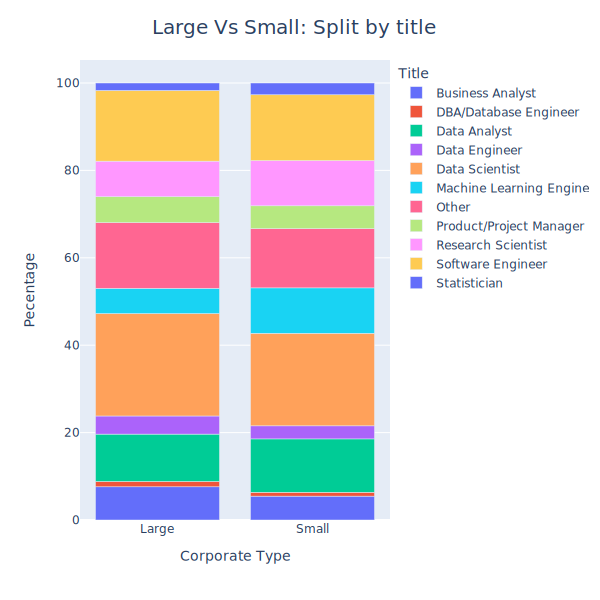

In [97]:
fig = px.bar(df_title, x="corp_type", y="percent", color="Q5" ,
    width = 600,
    height = 600)

fig.update_layout(legend_title_text = "Title")
fig.update_xaxes(title_text="Corporate Type")
fig.update_yaxes(title_text="Pecentage")

large_title_format = "<span style='font-size:20px; '>Large Vs Small: Split by title</span>"

fig.add_annotation(dict(
                            x= 1.1,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**A function for to compare a particular column values along with size of firm**

In [98]:
#Function to compare large and small firms
def compare_corp(column):
    '''
    Compares attribute in a column beginning with string passed along with size and returns percentages select in each category
    Parameters: 
        column(string):the column string to be compared along with size
    Returns:
        df_temp(dataframe):the datatframe grouped by column attributes and size with percenage contribution of each row
    '''
    
    df_temp = df.groupby(['corp_type',column]).size().reset_index(name='counts')
    df_temp= df_temp.pivot(index=df_temp.columns[1],columns='corp_type',values='counts')
    df_temp['Large']=df_temp['big']/df_temp['big'].sum()*100
    df_temp['Small']=df_temp['small']/df_temp['small'].sum()*100
    df_temp.reset_index(inplace=True)
    df_temp =df_temp [[column, 'Large', 'Small']]
    df_temp =pd.melt(df_temp ,id_vars=column, value_name='percent')
    return df_temp

**Visualising Choice of computing platform**<br>
Local machine is preferred choice. Surprisingly one would have expected small firms to be early adopters of cloud and to keep their fixed costs low. However, Cloud platforms are more prevelant in Large firms than small firms

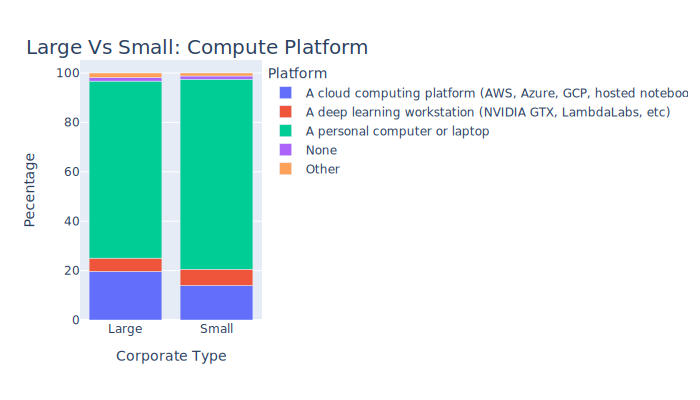

In [99]:
df_compute=compare_corp('Q11')

fig = px.bar(df_compute, x="corp_type", y="percent", color="Q11" ,
    width = 700,
    height = 400)

fig.update_layout(legend_title_text = "Platform")
fig.update_xaxes(title_text="Corporate Type")
fig.update_yaxes(title_text="Pecentage")

large_title_format = "<span style='font-size:20px; '>Large Vs Small: Compute Platform</span>"

fig.add_annotation(dict(
                            x= 1.5,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()


**Visualising ML Maturity**<br>
Large firms  have more models in production for more than two years than the small firms and also less percentage have reported not using any ML methods . That being said, most of the small firms would not have existed two years ago and also good place to start working from scratch in ML as response to question "We are exploring ML methods (and may one day put a model into production)" ratio is high in small firms  compared to large firms

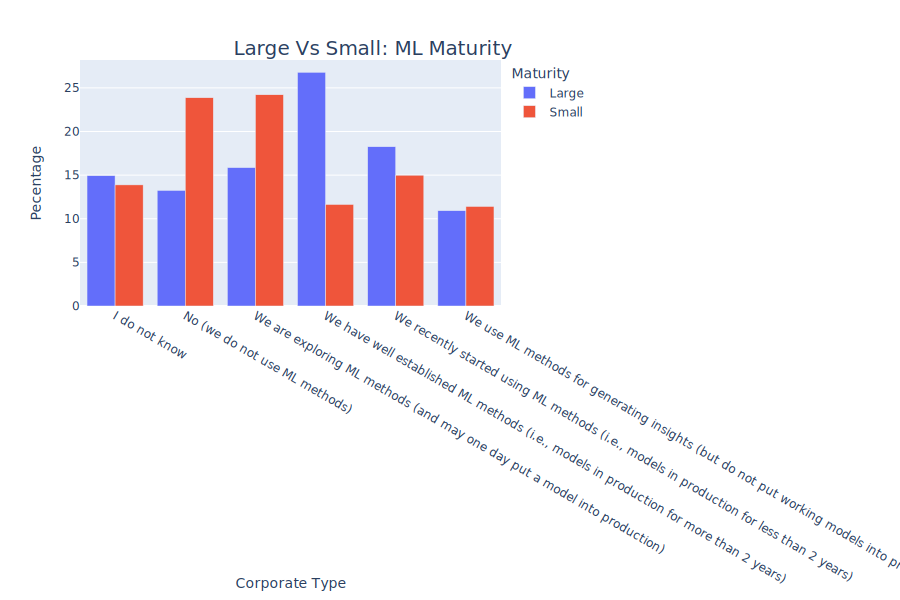

In [100]:
df_ml=compare_corp('Q22')
fig = px.bar(df_ml, x="Q22", y="percent", color="corp_type" , barmode='group',
    width = 900,
    height = 600)

fig.update_layout(legend_title_text = "Maturity")
fig.update_xaxes(title_text="Corporate Type")
fig.update_yaxes(title_text="Pecentage")

large_title_format = "<span style='font-size:20px; '>Large Vs Small: ML Maturity</span>"

fig.add_annotation(dict(
                            x= 1.0,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**Cleaning data to compare the language choices**


In [101]:
questions = df.columns

def compare_multiple(column):
    '''
    Compares multiple columns beginning with string keyword passed along with size and provides a percentage
    Parameters: 
        column(string):multiple columns beginning with string to be compared along with size
    Returns:
        df_temp(dataframe):the datatframe grouped by column attributes and size with percenage contribution of each row
    '''
    qtemp = [question for question in questions if column in question]

    # Creating labels for plot
    column_values = []
    for qn in qtemp:
        for value in df[qn].unique():
             column_values.append(value)

    column_values  = [str.strip(column_value) for column_value  in column_values  if str(column_value)!='nan']
   
    
    df_big=df[df['corp_type']=='big']
    
    big_lang = (df_big.shape[0] - df_big[qtemp].isnull().sum()) / df_big.shape[0]*100
    big_lang.index = column_values

    df_small=df[df['corp_type']=='small']
    small_lang = (df_small.shape[0] - df_small[qtemp].isnull().sum()) / df_small.shape[0]*100
    small_lang.index = column_values
    df_summary=big_lang.to_frame(name = 'Large').join(small_lang.to_frame(name = 'Small'))
    df_summary=df_summary[(df_summary['Large']>=15) | (df_summary['Small']>=15)]
    
    df_summary.reset_index(inplace=True)
    df_summary.columns=[column,'Large','Small']
    df_summary =pd.melt(df_summary ,id_vars=column, value_name='percent')
    return df_summary



**Language Choice**
Python is the leader of the pack everywhere. R and SQL is more popular in large firms but Javascript and C++ are slightly more popular in small firms. This could also mean Small firms may tend to work more on Edge devices compared to large firms.

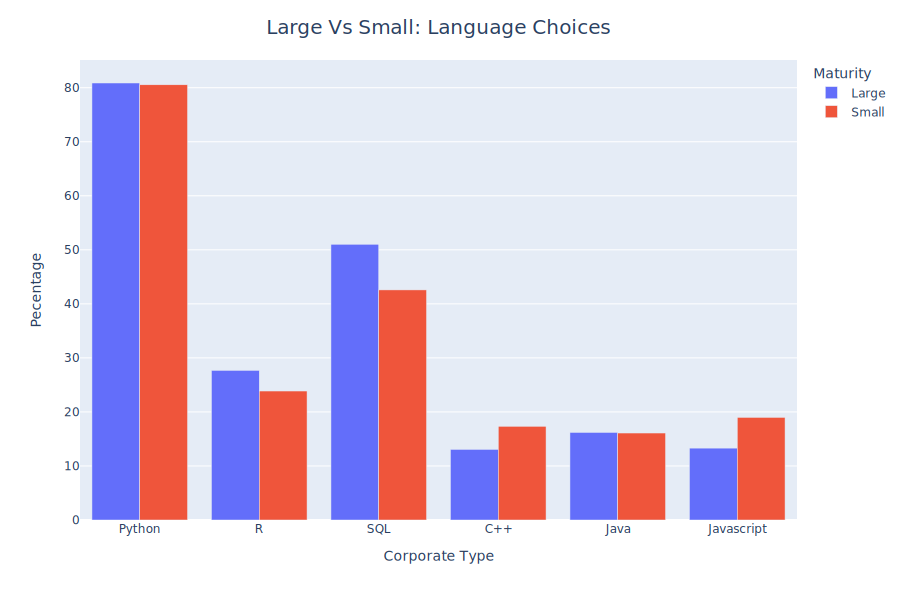

In [102]:
df_lang=compare_multiple('Q7')

fig = px.bar(df_lang, x="Q7", y="percent", color="variable" , barmode='group',
    width = 900,
    height = 600)

fig.update_layout(legend_title_text = "Maturity")
fig.update_xaxes(title_text="Corporate Type")
fig.update_yaxes(title_text="Pecentage")

large_title_format = "<span style='font-size:20px; '>Large Vs Small: Language Choices</span>"

fig.add_annotation(dict(
                            x= 0.5,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()



**Summary** <br>
* Thirve in place where ML and cloud adoption is mature with standard languages? Head to large firms
* Want to get your hands dirty in protyping and cloud configuration with non traditional ML languages too? Small firms are your best bet

# Second question: What is the future tech to learn? AWS or Google Cloud

**Gathering the data for tech analysis**

In [103]:
#reading again csv 
df=pd.read_csv("data/kaggle_survey_2020_responses.csv")
print("Survey (No of respondents,No of questions answered):",df.shape)

#let us drop second row with questions text
df=df.iloc[1:]
df['Q8'].value_counts(dropna=True)

Survey (No of respondents,No of questions answered): (20037, 355)


Python        14241
R              1259
SQL             849
C++             325
C               301
MATLAB          195
Java            167
Other           151
Julia           121
Javascript       88
None             81
Bash             26
Swift            17
Name: Q8, dtype: int64

What is the cloud platform data world is keen to get more familiar in next two years?
Amazon and Google are neck to neck in their offerings<br>
Function below to find a list of all columns in a dataframe beginning with a string

In [104]:
#Function to pick all columns beginning with particular Question number
def filter_col_startswith(column):
    '''
    Returns list of columns starting with the string passed
    Parameters: 
        column(string):string to be searched for all column beginnings
    Returns:
        df_temp(list):list of all columns beginning with the string
    '''
    filter_col = [col for col in df if col.startswith(column)]
    return filter_col

****Visualising cloud computing platforms ****

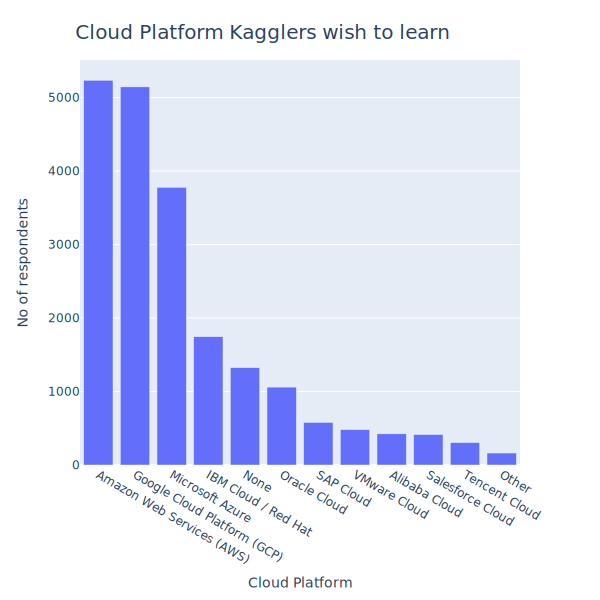

In [105]:
#Which of the following cloud computing platforms do you hope to become more familiar with in the next 2 years?

df_temp=df[filter_col_startswith('Q26_B_')].apply(pd.Series.value_counts).sum(axis=1).to_frame().reset_index()
df_temp.columns = ['Cloud Platform','No of Respondents']
df_temp.sort_values(by=['No of Respondents'], ascending=False,inplace=True)

fig = px.bar(df_temp, x="Cloud Platform", y="No of Respondents",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="Cloud Platform")
fig.update_yaxes(title_text="No of respondents")

large_title_format = "<span style='font-size:20px; '>Cloud Platform Kagglers wish to learn</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**Visualising cloud computing products**

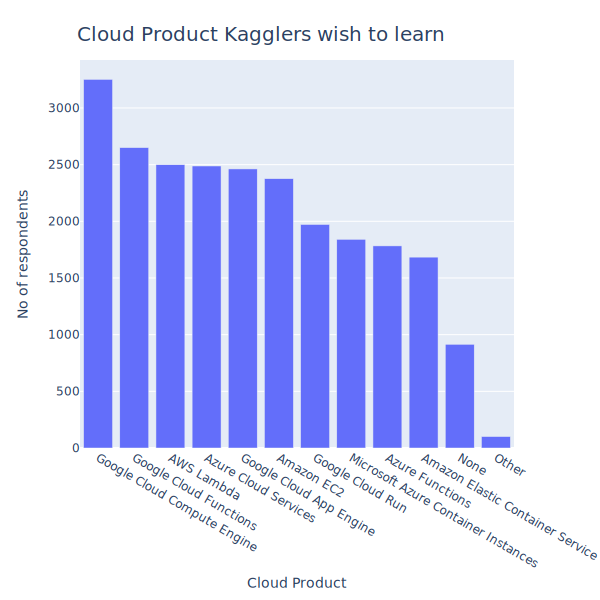

In [106]:
#In the next 2 years, do you hope to become more familiar with any of these specific cloud computing products?

df_temp=df[filter_col_startswith('Q27_B_')].apply(pd.Series.value_counts).sum(axis=1).to_frame().reset_index()
df_temp.columns = ['Cloud Product','No of Respondents']
df_temp.sort_values(by=['No of Respondents'], ascending=False,inplace=True)

fig = px.bar(df_temp, x="Cloud Product", y="No of Respondents",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="Cloud Product")
fig.update_yaxes(title_text="No of respondents")

large_title_format = "<span style='font-size:20px; '>Cloud Product Kagglers wish to learn</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**Visualising ML products**

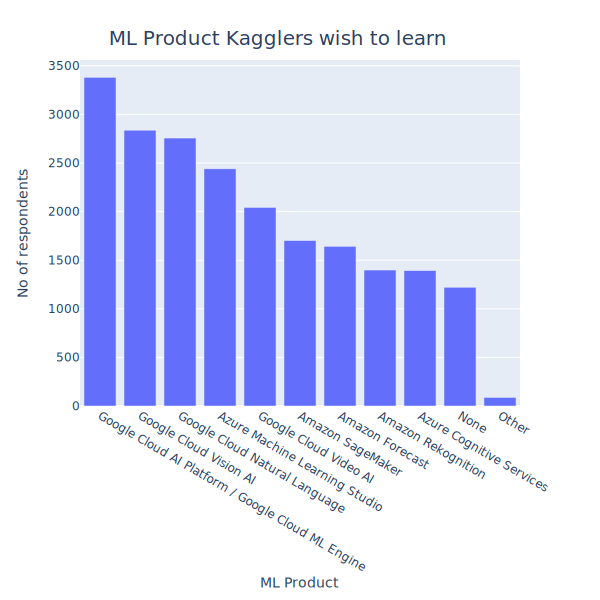

In [107]:
#In the next 2 years, do you hope to become more familiar with any of these specific machine learning products?

df_temp=df[filter_col_startswith('Q28_B_')].apply(pd.Series.value_counts).sum(axis=1).to_frame().reset_index()
df_temp.columns = ['ML Product','No of Respondents']
df_temp.sort_values(by=['No of Respondents'], ascending=False,inplace=True)
fig = px.bar(df_temp, x="ML Product", y="No of Respondents",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="ML Product")
fig.update_yaxes(title_text="No of respondents")

large_title_format = "<span style='font-size:20px; '>ML Product Kagglers wish to learn</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**Visualising ML experiments platforms**

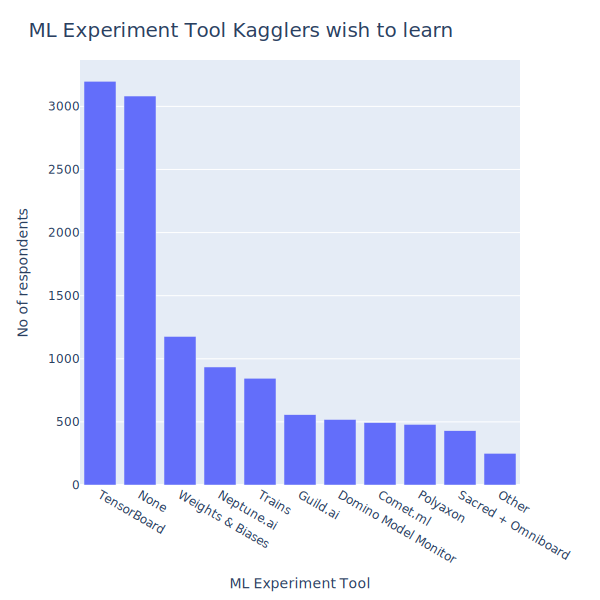

In [108]:
#In the next 2 years, do you hope to become more familiar with any of these tools for managing ML experiments? (Select all that apply)
df_temp=df[filter_col_startswith('Q35_B_')].apply(pd.Series.value_counts).sum(axis=1).to_frame().reset_index()
df_temp.columns = ['ML Experiment Tool','No of Respondents']
df_temp.sort_values(by=['No of Respondents'], ascending=False,inplace=True)
fig = px.bar(df_temp, x="ML Experiment Tool", y="No of Respondents",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="ML Experiment Tool")
fig.update_yaxes(title_text="No of respondents")

large_title_format = "<span style='font-size:20px; '>ML Experiment Tool Kagglers wish to learn</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()


**Summary**
AWS is leading in preferred cloud platform. However, Google beats hands down Amazon with  its imnpressive ecoystem starting with Google Compute, Google AI Platform and Tensorboard. Google seems to be an favorite over AWS atleast among Kagglers.

# Third: What are the factors that influence the salary adjusted for cost of living?

Gathering data for linear regression

In [109]:
#resetting the dataframes
df=pd.read_csv("data/kaggle_survey_2020_responses.csv")
df_livingcost=pd.read_csv("data/cost of living 2020.csv")

Cleaning the data by picking right columns, dropping all NaN, replacing salary category with median and merging with living cost

In [110]:
print(df.columns)
df=df.iloc[1:]

#Salary, Country, Experience, Programming lang,
df=df[['Q6','Q24','Q3','Q8','Q7_Part_1','Q7_Part_2','Q7_Part_3','Q7_Part_4','Q7_Part_5','Q7_Part_6','Q7_Part_7','Q7_Part_8','Q7_Part_9','Q7_Part_10','Q7_Part_11']]

#drop all nas in salary,country,experience
df=df[df['Q6'].notna()]
df=df[df['Q24'].notna()]
df=df[df['Q3'].notna()]

#replacing categories with midpoint of the range
df['Q24'].replace({'100,000-124,999':112000,
                     '15,000-19,999':17500,
                     '70,000-79,999':75000,
                     '30,000-39,999':35000,
                     '90,000-99,999':95000,
                     '1,000-1,999':1500,
                     '150,000-199,999':175000,
                     '60,000-69,999':65000,
                     '4,000-4,999':4500,
                     '> $500,000':500000,
                     '300,000-500,000':400000,
                     '40,000-49,999':45000,
                     '25,000-29,999':27500,
                     '80,000-89,999':85000,
                     '7,500-9,999':8750,
                     '50,000-59,999':55000,
                     '250,000-299,999':275000,
                     '5,000-7,499':6250,
                     '2,000-2,999':2500,
                     '20,000-24,999':22500,
                     '200,000-249,999':225000,
                     '3,000-3,999':3500,
                     '$0-999':750,
                     '10,000-14,999':12500,
                     '125,000-149,999':137500,
                    
                    }, inplace=True)

#merging with living cost data
df=pd.merge(df,df_livingcost, how='left', left_on='Q3', right_on='Country')
df=df[df['Q3']!='Other']

Index(['Time from Start to Finish (seconds)', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3',
       ...
       'Q35_B_Part_2', 'Q35_B_Part_3', 'Q35_B_Part_4', 'Q35_B_Part_5',
       'Q35_B_Part_6', 'Q35_B_Part_7', 'Q35_B_Part_8', 'Q35_B_Part_9',
       'Q35_B_Part_10', 'Q35_B_OTHER'],
      dtype='object', length=355)


**Assessing descriptive stats of the adjusted salary, dropping bottom 10 percentile as they seem unrealistic even after adjusting for cost of living and applying log transformation to reduce the right skewness**

In [111]:
#checking descriptive stats of the adjusted salary and 
df['adjusted_salary']=df['Q24']/(df['Cost of Living Index']/100)
print(df.agg(       {
            "adjusted_salary": ["min", "max", "median", "skew"]
       }
))

print(df['adjusted_salary'].dropna().quantile([0.0,.1,.2, .5, .90, .95]))

#dropping bottom 10 percentile as they seem unrealistic even after adjusting for cost of living
df=df[df['adjusted_salary']> 2495.840266]
#df=df[df['adjusted_salary']<  189043.742238]
#applying log transformation to reduce the right skewness
df['adjusted_salary']=np.log(df['adjusted_salary'])

#selecting the columns needed for linear regression
df=df[['Q6','Q3','Q7_Part_1','Q7_Part_2','Q7_Part_3','Q7_Part_4','Q7_Part_5','Q7_Part_6','Q7_Part_7','Q7_Part_8','Q7_Part_9','Q7_Part_10','Q7_Part_11','adjusted_salary']]

        adjusted_salary
min        8.698678e+02
max        2.380952e+06
median     5.182421e+04
skew       6.448621e+00
0.00       869.867780
0.10      2495.840266
0.20      3109.452736
0.50     51824.212272
0.90    189733.682903
0.95    263792.583660
Name: adjusted_salary, dtype: float64


**Visualising the salary boxplot before processing**

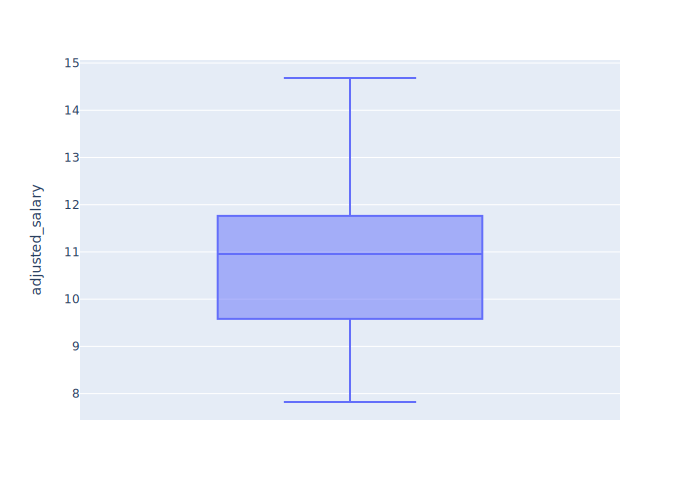

In [112]:
fig = px.box(df, y='adjusted_salary')
fig.show()

**Encoding categorical variables**

In [113]:
#convert categorical vlaues into dummy variables and picking t
exp= pd.get_dummies(df['Q6'], prefix='exp', drop_first=True,dummy_na=True)
ct = pd.get_dummies(df['Q3'], prefix='ct', drop_first=True,dummy_na=True)
python= pd.get_dummies(df['Q7_Part_1'], drop_first=True,dummy_na=True)
r= pd.get_dummies(df['Q7_Part_2'], drop_first=True,dummy_na=True)
sql= pd.get_dummies(df['Q7_Part_3'], drop_first=True,dummy_na=True)
c= pd.get_dummies(df['Q7_Part_4'], drop_first=True,dummy_na=True)
cplusplus= pd.get_dummies(df['Q7_Part_5'], drop_first=True,dummy_na=True)
java= pd.get_dummies(df['Q7_Part_6'], drop_first=True,dummy_na=True)
javascript= pd.get_dummies(df['Q7_Part_7'], drop_first=True,dummy_na=True)
julia= pd.get_dummies(df['Q7_Part_8'], drop_first=True,dummy_na=True)
swift= pd.get_dummies(df['Q7_Part_9'], drop_first=True,dummy_na=True)
bash= pd.get_dummies(df['Q7_Part_10'], drop_first=True,dummy_na=True)
matlab= pd.get_dummies(df['Q7_Part_11'], drop_first=True,dummy_na=True)


Creating the final data frame for linear regression by adding all the columns

In [114]:
#creating the final dataset for linear regression
df_processed=pd.concat([python,r,sql,c,cplusplus,java,javascript,julia,swift,bash,matlab ],axis=1)
df_processed.columns =['lang_python','lang_r','lang_sql','lang_c','lang_cplusplus','lang_java','lang_javascript','lang_julia','lang_swift','lang_bash','lang_matlab']
df_processed=pd.concat([df['adjusted_salary'],exp,ct,df_processed],axis=1)
df_processed=df_processed.drop('exp_nan',axis=1)
df_processed=df_processed.drop('ct_nan',axis=1)

**Modelling the dataframe for linear regression analysis**

In [115]:
#linear regression from scikit
X=df_processed.drop('adjusted_salary',axis=1)
y=df_processed['adjusted_salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 1.3328847607945835
Test Mean Squarred Error: 1.5096075418376957


Persisting the model output

In [116]:
#printing the coefficients
print(linreg.intercept_)
print(linreg.score(X,y))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(linreg.coef_))], axis = 1)
coefficients.to_csv('coefficients.csv',index=False)

9.855740973419401
0.3748360053807097


In [117]:
#renaming columns
coefficients.columns=['Variable','Coefficient']

In [118]:
#Function to pick all rows beginning with particular string
def filter_row_startswith(df,column,keyword,sortcolumn):
    '''
    Returns top 10 rows starting with the string passed and sorts descenging based on columne provided for clean charts
    Parameters: 
        df(dataframe):datframe to be processed
        column(string): column on which the filter to be applied
        keyword(string):string to be searched in rows
        sortcolumn(String):column to be sorted descending
        
    Returns:
        filter_row(dataframe):dataframe of top 10 rows which are filtered and sorted 
    '''
    filter_row = df[df[column].str.startswith(keyword)]
    return filter_row.sort_values(by=sortcolumn,ascending=False).head(10)

**Visualising the coefficients**

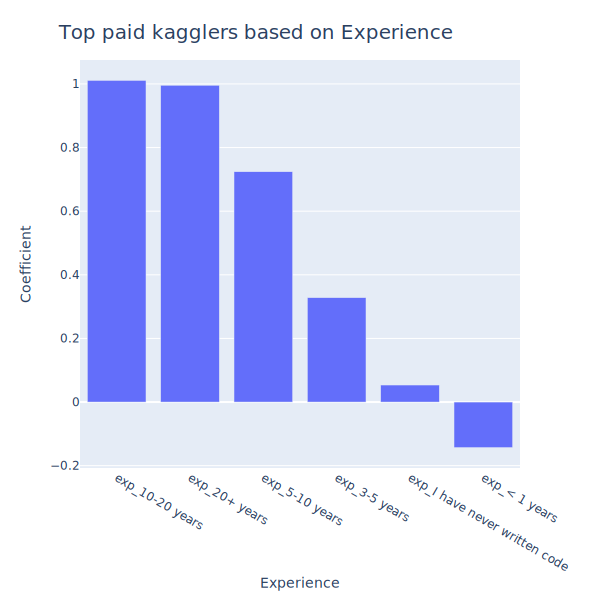

In [119]:
#plotting to map coefficients - Experience
df_temp=filter_row_startswith(coefficients,'Variable','exp','Coefficient')
fig = px.bar(df_temp, x="Variable", y="Coefficient",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="Experience")
fig.update_yaxes(title_text="Coefficient")

large_title_format = "<span style='font-size:20px; '>Top paid kagglers based on Experience</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()



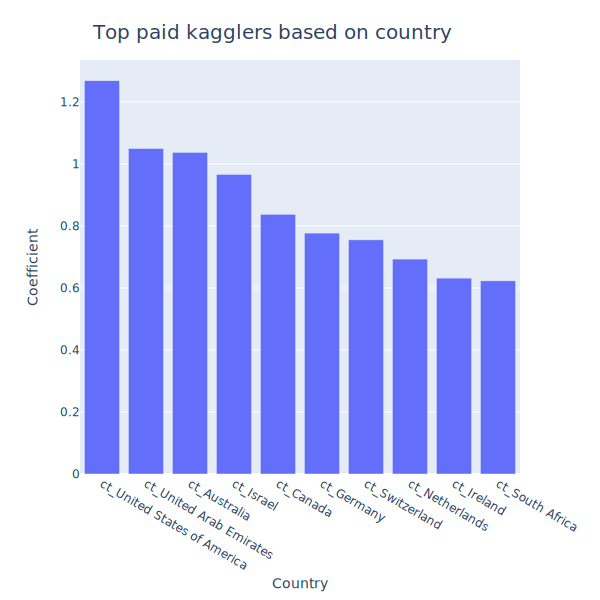

In [120]:
#plotting to map coefficients - Country
df_temp=filter_row_startswith(coefficients,'Variable','ct','Coefficient')
fig = px.bar(df_temp, x="Variable", y="Coefficient",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Coefficient")

large_title_format = "<span style='font-size:20px; '>Top paid kagglers based on country</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()



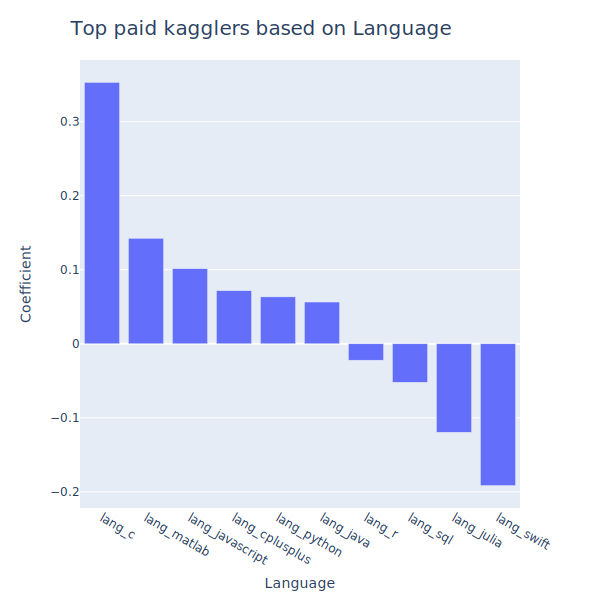

In [121]:
#plotting to map coefficients - Langauge
df_temp=filter_row_startswith(coefficients,'Variable','lang','Coefficient')
fig = px.bar(df_temp, x="Variable", y="Coefficient",
    width = 600,
    height = 600)


fig.update_xaxes(title_text="Language")
fig.update_yaxes(title_text="Coefficient")

large_title_format = "<span style='font-size:20px; '>Top paid kagglers based on Language</span>"

fig.add_annotation(dict(
                            x= 0.8,
                            y=1.1,
                            showarrow=False,
                            text= large_title_format + "<br><br>" ,
                            textangle=0,
                            xref="paper",
                            yref="paper"
                           ))
fig.show()

**Summary 3**<br>
Experienced personnel as expected earn more. In terms of country, USA and UAE top the list of better pay even after adjusting for cost of living. Python being common for almost 90% of people,C and Matlab top the list. One reason is they could be top choice for people with high experience as well.

# Appendix
**References**
1. https://www.kaggle.com/joeypp/cost-of-living-numbeo-dataset
2. https://www.kaggle.com/spitfire2nd/enthusiast-to-data-professional-what-changes/
3. https://www.kaggle.com/kailex/education-languages-and-salary


**Recreating Linear regression using stats model for validation**

In [122]:
#Testing for R2 
df_processed.columns = [c.replace(' ', '') for c in df_processed.columns]
df_processed.columns = [str(c).lower() for c in df_processed.columns]
df_processed.columns = [c.replace('<', '') for c in df_processed.columns]
df_processed.columns = [c.replace('-', '') for c in df_processed.columns]
df_processed.columns = [c.replace('+', '') for c in df_processed.columns]

str1 = df_processed.columns[0] + " ~ " + " + ".join(list(df_processed.columns[1:len(df_processed.columns)]))
model = ols(formula=str1,data=df_processed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        adjusted_salary   R-squared:                       0.376
Model:                            OLS   Adj. R-squared:                  0.371
Method:                 Least Squares   F-statistic:                     76.50
Date:                Sat, 03 Jul 2021   Prob (F-statistic):               0.00
Time:                        16:58:20   Log-Likelihood:                -13278.
No. Observations:                8433   AIC:                         2.669e+04
Df Residuals:                    8366   BIC:                         2.716e+04
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     9.7986      0.225     43.518      0.000       9.357      10.240
exp_1020years                 0.9758      0.048     20.364      0.000       0.882       1.070
exp_20years                   0.9707      0.053     18.223      0.000       0.866       1.075
exp_35years                   0.2961      0.041      7.198      0.000       0.215       0.377
exp_510years                  0.6907      0.044     15.596      0.000       0.604       0.777
exp_1years                   -0.1412      0.049     -2.870      0.004      -0.238      -0.045
exp_ihaveneverwrittencode     0.0692      0.076      0.912      0.362      -0.080       0.218
ct_australia                  0.9896      0.179      5.537      0.000       0.639       1.340
ct_bangladesh                -0.6187      0.269     -2.298      0.022      -1.146      -0.091
ct_belarus                   -0.0295      0.259     -0.114      0.909      -0.538       0.479
ct_belgium                    0.1351      0.266      0.509      0.611      -0.385       0.656
ct_brazil                     0.1426      0.158      0.904      0.366      -0.167       0.452
ct_canada                     0.9414      0.170      5.539      0.000       0.608       1.275
ct_chile                      0.0728      0.218      0.335      0.738      -0.354       0.499
ct_china                      0.5161      0.181      2.852      0.004       0.161       0.871
ct_colombia                  -0.3962      0.181     -2.188      0.029      -0.751      -0.041
ct_egypt                     -1.0995      0.191     -5.744      0.000      -1.475      -0.724
ct_france                     0.3743      0.171      2.188      0.029       0.039       0.710
ct_germany                    0.7999      0.165      4.851      0.000       0.477       1.123
ct_ghana                     -0.4105      0.337     -1.220      0.223      -1.070       0.249
ct_greece                    -0.0844      0.217     -0.388      0.698      -0.511       0.342
ct_india                     -0.2052      0.149     -1.382      0.167      -0.496       0.086
ct_indonesia                 -0.4004      0.204     -1.960      0.050      -0.801       0.000
ct_ireland                    0.5508      0.257      2.147      0.032       0.048       1.054
ct_israel                     0.9207      0.213      4.317      0.000       0.503       1.339
ct_italy                      0.2858      0.174      1.645      0.100      -0.055       0.626
ct_japan                      0.2281      0.161      1.421      0.155      -0.087       0.543
ct_kenya                     -0.5367      0.227     -2.369      0.018      -0.981      -0.093
ct_malaysia                   0.1015      0.228      0.445      0.656      -0.345       0.548
ct_mexico                     0.3369      0.182      1.854      0.064      